In [1]:
import pandas as pd
import tensorflow as tf
import yfinance as yf
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input,GlobalAveragePooling1D
from keras import optimizers
import matplotlib.pyplot as plt
import keras_tuner as kt
from datetime import datetime, timedelta
import math

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
policy = keras.mixed_precision.Policy('mixed_float16')
keras.mixed_precision.set_global_policy(policy)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16638067227258448125
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5729419264
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14271248395393718624
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4060 Laptop GPU, compute capability 8.9


In [3]:
timestep = 100
testfrac = 0.25
valfrac = 0.2

In [4]:
start_date = '2010-01-01'
today = datetime.now()
end_date = datetime.strftime(today, '%Y-%m-%d')
display(end_date)
data = yf.download("ETH-USD", start=start_date, end=end_date) #Displays till yesterday as today is not complete
data = data.reset_index()
dataclose = np.array([data['Close']]).transpose()
display(dataclose.shape)

'2024-01-22'

[*********************100%%**********************]  1 of 1 completed


(2264, 1)

,Open,High,Low,Close,Volume
0,308.644989,329.451996,307.056000,320.884003,893249984
1,320.670990,324.717987,294.541992,299.252991,885985984
2,298.585999,319.453003,298.191986,314.681000,842300992
3,314.690002,319.153015,298.513000,307.907990,1613479936
4,307.024994,328.415009,307.024994,316.716003,1041889984
...,...,...,...,...,...
2259,2510.627197,2613.566895,2500.003906,2587.691162,11063317095
2260,2587.044678,2592.737061,2508.432861,2528.369385,10441017520
2261,2528.593262,2546.263916,2426.135498,2467.018799,11900028080
2262,2468.688965,2501.305176,2414.710938,2489.498535,11405278376


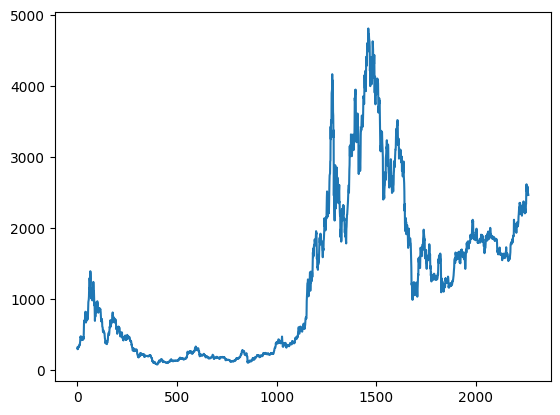

In [5]:
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
display(data)
plt.plot(dataclose)
plt.show()

In [6]:
Xscaler = MinMaxScaler()
Xdata = Xscaler.fit_transform(np.array(data))
Yscaler = MinMaxScaler()
Ydata = Yscaler.fit_transform(dataclose)
display(Xdata.shape)
display(Ydata.shape)

(2264, 5)

(2264, 1)

In [7]:
X_temp, X_test = train_test_split(Xdata, test_size=testfrac, shuffle=False)
Y_temp, Y_test = train_test_split(Ydata, test_size=testfrac, shuffle=False)
X_train, X_val = train_test_split(X_temp, test_size=valfrac, shuffle=False)
Y_train, Y_val = train_test_split(Y_temp, test_size=valfrac, shuffle=False)

In [8]:
def build_timeseries(Xdata, Ydata, time_step):
    dim_0 = Xdata.shape[0] - time_step
    dim_1 = Xdata.shape[1]

    x = np.zeros((dim_0, time_step, dim_1))
    y = np.zeros((Ydata.shape[0] - time_step,))

    for i in range(dim_0):
        x[i] = Xdata[i:time_step+i]
        y[i] = Ydata[time_step+i]
    return x, y

In [9]:
X_train, Y_train = build_timeseries(X_train, Y_train, timestep)
X_test, Y_test = build_timeseries(X_test, Y_test, timestep)
X_val, Y_val = build_timeseries(X_val, Y_val, timestep)
print("X Train Shape: ", X_train.shape, "   Y Train Shape: ", Y_train.shape)
print("X Val Shape: ", X_val.shape, "   Y Val Shape: ", Y_val.shape)
print("X Test Shape: ", X_test.shape, "   Y Test Shape: ", Y_test.shape)

X Train Shape:  (1258, 100, 5)    Y Train Shape:  (1258,)
X Val Shape:  (240, 100, 5)    Y Val Shape:  (240,)
X Test Shape:  (466, 100, 5)    Y Test Shape:  (466,)


C:\Users\user\AppData\Local\Temp\ipykernel_5272\2375792492.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i] = Ydata[time_step+i]


In [10]:
def model_builder(hp):
    lstm_model = Sequential()
    
    lstm_units_0 = hp.Int('units_lstm_0', min_value=128, max_value=256, step=64)
    lstm_units_1 = hp.Int('units_lstm_1', min_value=16, max_value=256, step=64)
    dense_units_0 = hp.Int('units_dense_0', min_value=16, max_value=128, step=64)
    lstm_layers = hp.Int('lstm_layers', min_value=1, max_value=4, step=1)
    dense_relu_layers = hp.Int('dense_relu_layers', min_value=1, max_value=4, step=1)
    dense_lin_layers = hp.Int('dense_lin_layers', min_value=1, max_value=4, step=1)
    lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    lstm_model.add(LSTM(units=lstm_units_0, return_sequences=True))
    for i in range(lstm_layers):
        lstm_model.add(LSTM(units=lstm_units_1, return_sequences=True))
    lstm_model.add(GlobalAveragePooling1D())
    for j in range(dense_relu_layers):
        lstm_model.add(Dense(units=dense_units_0,activation='relu'))
    lstm_model.add(Dropout(0.05))
    for k in range(dense_lin_layers):
        lstm_model.add(Dense(units=dense_units_0, activation='linear'))
    lstm_model.add(Dense(units=1))
    lstm_model.summary()
    
    hyperparameters_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.05, 0.1])
    
    lstm_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=hyperparameters_learning_rate))
    
    return lstm_model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 1224)         6022080   
                                                                 
 lstm_1 (LSTM)               (None, 100, 612)          4496976   
                                                                 
 lstm_2 (LSTM)               (None, 100, 612)          2998800   
                                                                 
 lstm_3 (LSTM)               (None, 100, 612)          2998800   
                                                                 
 lstm_4 (LSTM)               (None, 100, 256)          889856    
                                                                 
 lstm_5 (LSTM)               (None, 100, 256)          525312    
                                                                 
 global_average_pooling1d (G  (None, 256)              0

In [ ]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_loss',
    max_trials=100)
tuner.search(X_train, Y_train, epochs=25, validation_data=(X_val,Y_val))
lstm_model  = tuner.get_best_models()[0]  
print(lstm_model.summary())
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [11]:
lstm_model.fit(X_train,Y_train,validation_data = (X_val,Y_val),epochs = 250,batch_size = 128,verbose = 1)

Epoch 1/100
20/20 [==============================] - 11s 165ms/step - loss: 0.0241 - val_loss: 0.0552
Epoch 2/100
20/20 [==============================] - 2s 95ms/step - loss: 0.0041 - val_loss: 0.0496
Epoch 3/100
20/20 [==============================] - 2s 94ms/step - loss: 0.0026 - val_loss: 0.0471
Epoch 4/100
20/20 [==============================] - 2s 91ms/step - loss: 0.0028 - val_loss: 0.0532
Epoch 5/100
20/20 [==============================] - 2s 92ms/step - loss: 0.0025 - val_loss: 0.0770
Epoch 6/100
20/20 [==============================] - 2s 92ms/step - loss: 0.0042 - val_loss: 0.0346
Epoch 7/100
20/20 [==============================] - 2s 92ms/step - loss: 0.0120 - val_loss: 0.1017
Epoch 8/100
20/20 [==============================] - 2s 91ms/step - loss: 0.0041 - val_loss: 0.0514
Epoch 9/100
20/20 [==============================] - 2s 91ms/step - loss: 0.0027 - val_loss: 0.0424
Epoch 10/100
20/20 [==============================] - 2s 91ms/step - loss: 0.0027 - val_loss: 0.06

In [12]:
train_predict = lstm_model.predict(X_train)
val_predict = lstm_model.predict(X_val)
test_predict = lstm_model.predict(X_test)
train_predictraw = Yscaler.inverse_transform(train_predict).reshape((train_predict.shape[0],))
val_predictraw = Yscaler.inverse_transform(val_predict).reshape((val_predict.shape[0],))
test_predictraw = Yscaler.inverse_transform(test_predict).reshape((test_predict.shape[0],))

15/15 [==============================] - 0s 27ms/step


In [13]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)))
print(math.sqrt(mean_squared_error(Y_val,val_predict)))
print(math.sqrt(mean_squared_error(Y_test,test_predict)))

0.13943630093750703
0.44521775379371265
0.2387124075310054


In [14]:
dataclose = dataclose.transpose()[0]
display(dataclose)

array([ 320.88400269,  299.25299072,  314.68099976, ..., 2467.01879883,
       2489.49853516, 2469.58911133])

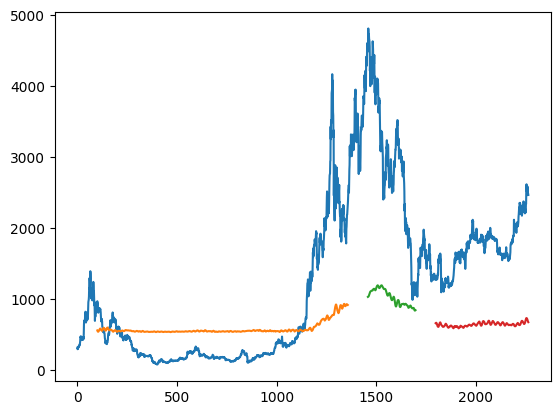

In [15]:
plt.plot(dataclose)

trainPredictPlot = np.empty_like(dataclose)
trainPredictPlot.fill(np.nan)
trainPredictPlot[timestep:len(train_predictraw)+timestep:] = train_predictraw
plt.plot(trainPredictPlot)

valPredictPlot = np.empty_like(dataclose)
valPredictPlot.fill(np.nan)
valPredictPlot[len(train_predictraw)+timestep*2:len(train_predictraw)+timestep*2+len(val_predictraw):] = val_predictraw
plt.plot(valPredictPlot)

testPredictPlot = np.empty_like(dataclose)
testPredictPlot.fill(np.nan)
testPredictPlot[len(train_predictraw)+timestep*3+len(val_predictraw):len(train_predictraw)+timestep*3+len(val_predictraw)+len(test_predictraw):] = test_predictraw
plt.plot(testPredictPlot)

plt.show()